In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import re

In [4]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [5]:
random_seed = 42
early_stopping_round = 100

## funcs

In [6]:
def get_dataset(folder_paths: list, filename_features: str, filename_target: str):
    X = pd.DataFrame()
    y = pd.DataFrame()
    for folder in folder_paths:
        X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
        y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
        
        is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
        is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
        if is_unnamed:
            X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
        if is_unnamed_y:
            y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
        
        # if X_tmp.columns[0] != "y":
        #     col_y = np.ones(X_tmp.shape[0]) * 1000
        #     X_tmp.insert(0, "y", col_y)
        
        print(X_tmp.shape, y_tmp.shape)
        X = pd.concat([X, X_tmp], axis = 0)
        y = pd.concat([y, y_tmp], axis = 0)
    X.reset_index(inplace=True, drop=True)
    y.reset_index(inplace=True, drop=True)
    print(X.shape, y.shape)
    return X, y

In [7]:
def add_exp_num(X):
    tracers_num = len(np.unique(X["Tracer"]))
    distances_num = len(np.unique(X["distances"]))
    experiment_num = []
    for exp in range(X.shape[0]//(tracers_num*distances_num)):
        experiment_num.extend(list(np.ones(tracers_num*distances_num) * (exp + 1)))
    X["experiment_num"] = experiment_num
    return X

In [8]:
def data_split(X, y, test_size = 0.2, valid_size = None, eval_size = None, random_seed = random_seed):
    rng = np.random.default_rng(seed=random_seed)
    
    experiment_nums = X["experiment_num"].unique()
    total_experiments = len(experiment_nums)
    
    n_test = int(test_size * total_experiments)
    
    splits = {}
    remaining_exps = set(experiment_nums)
    
    test_experiments = set(rng.choice(list(remaining_exps), n_test, replace=False))
    remaining_exps -= test_experiments
    splits['test'] = {
        'X': X[X["experiment_num"].isin(test_experiments)].copy(),
        'y': None
    }
    
    if valid_size:
        n_valid = int(valid_size * (total_experiments - n_test))
        valid_experiments = set(rng.choice(list(remaining_exps), n_valid, replace=False))
        remaining_exps -= valid_experiments
        splits['valid'] = {
            'X': X[X["experiment_num"].isin(valid_experiments)].copy(),
            'y': None
        }
    
    if eval_size:
        n_eval = int(eval_size * (total_experiments - n_test - n_valid))
        eval_experiments = set(rng.choice(list(remaining_exps), n_eval, replace=False))
        remaining_exps -= eval_experiments
        
        splits['eval'] = {
            'X': X[X["experiment_num"].isin(eval_experiments)].copy(),
            'y': None
        }
    
    splits['train'] = {
        'X': X[X["experiment_num"].isin(remaining_exps)].copy(),
        'y': None
    }
    
    for split_name in splits:
        splits[split_name]['y'] = y.loc[splits[split_name]['X'].index].copy()
    
    split_shapes = [f"{name}: X{splits[name]['X'].shape}, y{splits[name]['y'].shape}" 
                   for name in ['train', 'test', 'valid', 'eval'] 
                   if name in splits]
    print(f"Split shapes: {', '.join(split_shapes)}")
    
    if valid_size and eval_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'], splits['eval']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'], splits['eval']['y'])
    elif valid_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'])
    else:
        return splits['train']['X'], splits['test']['X'], splits['train']['y'], splits['test']['y']

In [9]:
def del_outs(X, y):
    #Delete zeros
    mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
    X = X[mask]
    y = y[mask]
    points = np.linspace(0, np.max(y["c_std_y"]), 200)
    quantiles = np.histogram(y["c_std_y"], points)
    hist_mode = quantiles[1][np.argmax(quantiles[0])]
    cut_mask = y["c_std_y"] >= hist_mode
    X = X[cut_mask]
    y = y[cut_mask]
    print(X.shape, y.shape)
    return X, y

In [10]:
def make_means_target(X, y):
    y["c_mean_y"] = X["y"] - y["c_mean_y"]
    y["c_mean_z"] = X["z"] - y["c_mean_z"]
    return y

In [11]:
def del_columns(X, columns):
    X.drop(columns=columns, inplace=True)
    # return X


## begin

In [12]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [13]:
specific_features= pd.DataFrame({"y": [500.0],
                                "z": [156.25],
                                "u": [7.5],
                                "power":[1.1],
                                "roughness": [0.1],
                                "T": [241.0],
                                "sensible_heat_flux":[-0.35],
                                "T_grad":[0.03],
                                "distances": [1054.6875]})

In [14]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [15]:
folder_paths = ["output_19_01_2025_2"]

In [16]:
X, y = get_dataset(folder_paths, filename_features, filename_target)

(2322432, 10) (2322432, 4)
(2322432, 10) (2322432, 4)


In [17]:
y = make_means_target(X, y)

In [18]:
y.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)

In [19]:
X = add_exp_num(X)

## Delete zeros

In [20]:
X, y = del_outs(X, y)

(2312849, 11) (2312849, 4)


## EDA

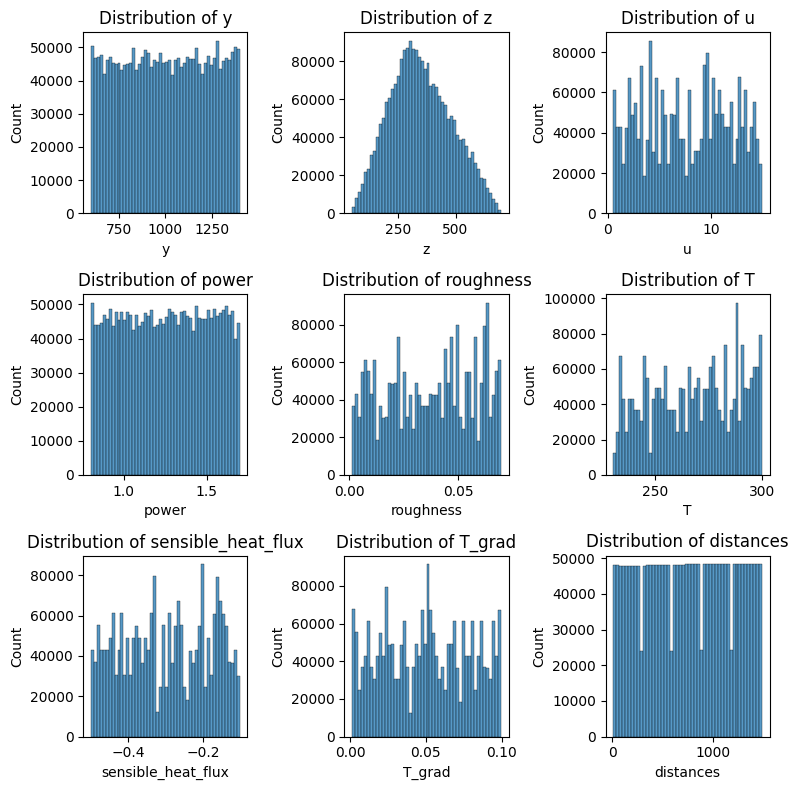

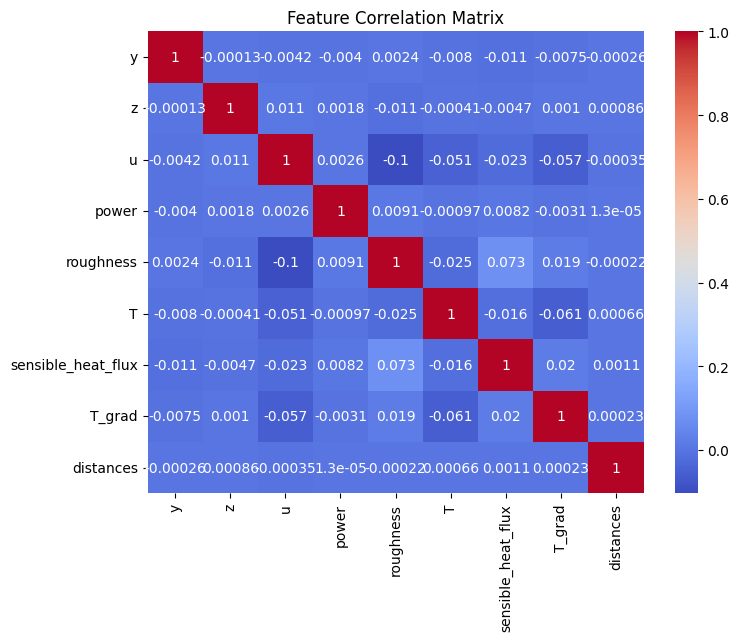

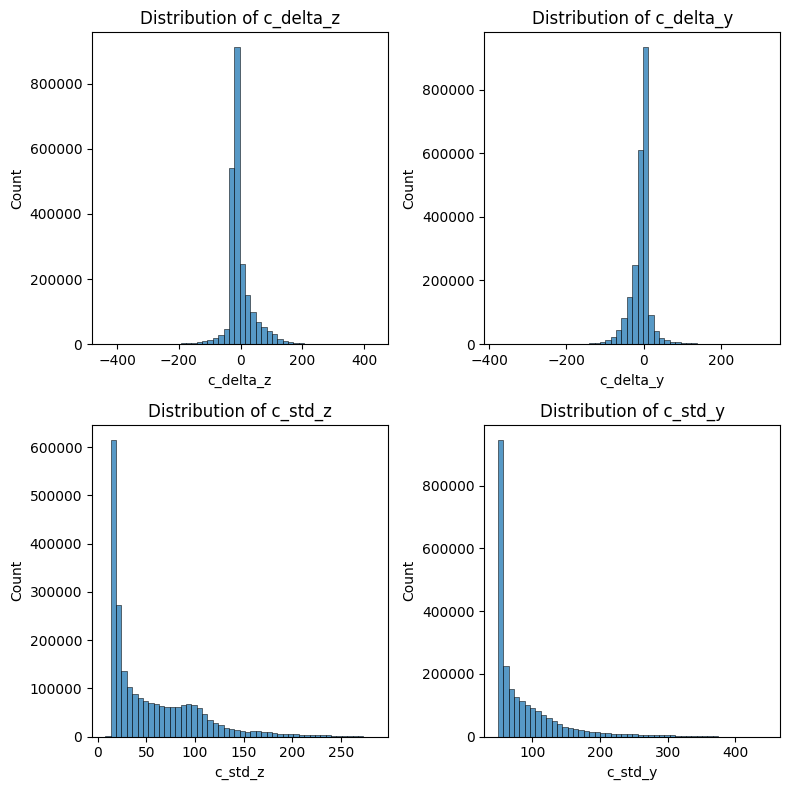

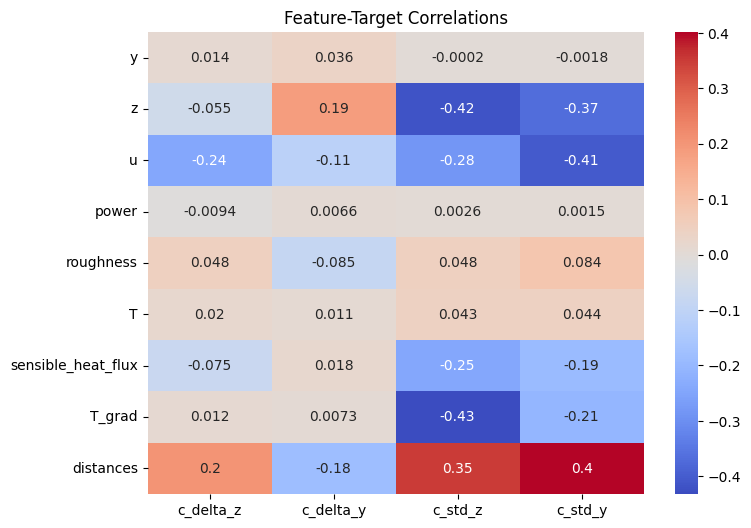

In [19]:
perform_eda(X[X.columns[1:-1]], y)

## Test-train split

In [21]:
# X_train, X_test, X_valid, X_eval, y_train, y_test, y_valid, y_eval = data_split(X, y, test_size=0.2, valid_size=0.2, eval_size=0.1)
X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.2)

Split shapes: train: X(1853505, 11), y(1853505, 4), test: X(459344, 11), y(459344, 4)


In [22]:
del_columns(X_train, ["experiment_num", "Tracer"])
del_columns(X_test, ["experiment_num", "Tracer"])
# del_columns(X_valid, ["experiment_num", "Tracer"])
# del_columns(X_eval, ["experiment_num", "Tracer"])

In [ ]:
# X_part, X_test, y_part, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [ ]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_part, y_part, test_size=0.2, random_state=random_seed)
# X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
# X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

In [ ]:
# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

In [ ]:
# perform_eda_short(X_test, y_test)

In [101]:
X_test_cut = X_test[X_test["distances"] > 490].copy()
y_test_cut = y_test.loc[X_test_cut.index]
X_train_cut = X_train[X_train["distances"] > 490].copy()
y_train_cut = y_train.loc[X_train_cut.index] 

## Feature engineering

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import quantile_transform, power_transform

In [24]:
class TargetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, near_zero = 1e-3):
        self.near_zero = near_zero

    def fit(self, data: pd.DataFrame, *args):
        self.columns = data.columns
        self.std_y_bias = np.min(data["c_std_y"])
        self.std_z_bias = np.min(data["c_std_z"])
        
        self.std_y_std = np.std(data["c_std_y"])
        self.std_z_std = np.std(data["c_std_z"])

        self.mean_y_mean = np.mean(data["c_delta_y"])
        self.mean_z_mean = np.mean(data["c_delta_z"])

        self.mean_y_std = np.std(data["c_delta_y"])
        self.mean_z_std = np.std(data["c_delta_z"])

        self.mean_y_minuses = data.index[data["c_delta_y"] < 0].to_list()
        self.mean_z_minuses = data.index[data["c_delta_z"] < 0].to_list()

        return self

    def transform(self, data: pd.DataFrame):
        data["c_std_y"] -= self.std_y_bias - self.near_zero
        data["c_std_z"] -= self.std_z_bias - self.near_zero
        data["c_std_y"] = np.log(data["c_std_y"])
        data["c_std_z"] = np.log1p(data["c_std_z"])
        
        mean_y_sign = np.sign(data["c_delta_y"])
        data["c_delta_y"] = np.abs(data["c_delta_y"])       
        data["c_delta_y"] = np.log1p(data["c_delta_y"])
        data["c_delta_y"]*=mean_y_sign
        
        data["c_delta_z"] = (data["c_delta_z"] - self.mean_z_mean)/self.mean_z_std
        mean_z_sign = np.sign(data["c_delta_z"])
        data["c_delta_z"]= mean_z_sign * np.log1p(np.abs(data["c_delta_z"]))
        
        return data
    
    def inverse_transform(self, data: pd.DataFrame):
      
        data["c_std_y"] = np.exp(data["c_std_y"])
        data["c_std_z"] = np.expm1(data["c_std_z"])
        data["c_std_y"] += self.std_y_bias - self.near_zero
        data["c_std_z"] += self.std_z_bias - self.near_zero
        
        mean_y_sign = np.sign(data["c_delta_y"])
        data["c_delta_y"] = np.abs(data["c_delta_y"])
        data["c_delta_y"] = np.expm1(data["c_delta_y"])
        data["c_delta_y"] *=mean_y_sign
        
        mean_z_sign = np.sign(data["c_delta_z"])
        data["c_delta_z"] = np.expm1(np.abs(data["c_delta_z"]))
        data["c_delta_z"] *=mean_z_sign
        data["c_delta_z"] = data["c_delta_z"] * self.mean_z_std + self.mean_z_mean
        return data


In [18]:
# y_train_1 = y_train.copy()
# target_pr = TargetPreprocessor()
# target_pr.fit(y_train_1)
# target_pr.transform(y_train_1)
# y_eval_1 = y_eval.copy()
# target_pr.transform(y_eval_1)
# target_pr.transform(y_valid)

In [ ]:
y_train.hist(bins=50)

In [26]:
y_1 = y_train.copy()

In [27]:
t_preproc = TargetPreprocessor()
# t_preproc.fit(y)
t_preproc.fit(y)
y_1 = t_preproc.transform(y_1)
print()
# perform_eda_short(X_train, y_train)

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

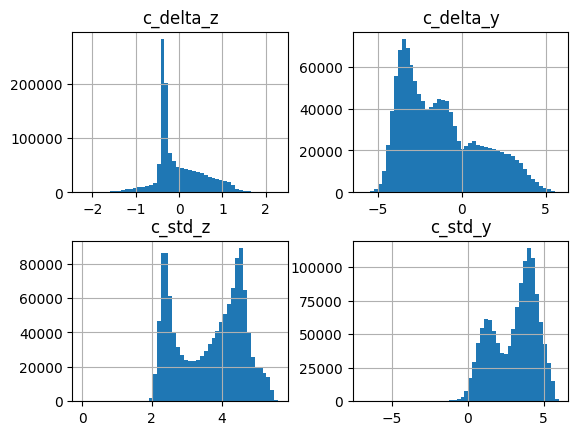

In [111]:
y_1.hist(bins=50)

In [112]:
t_preproc.inverse_transform(y_1)
print()

array([[<Axes: title={'center': 'c_delta_z'}>,
        <Axes: title={'center': 'c_delta_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

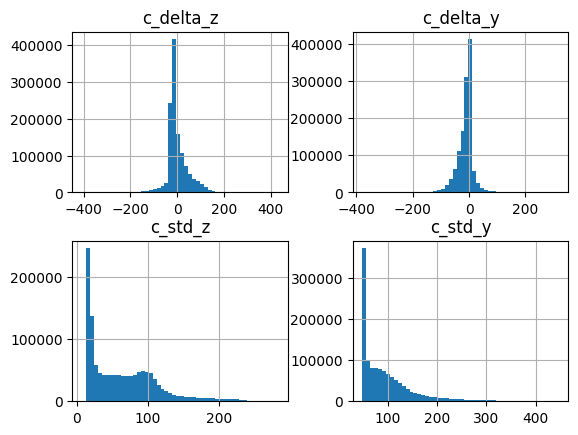

In [113]:
y_1.hist(bins=50)

In [120]:
np.sum(np.abs(y_train_cut - y_1), axis=0) 

c_delta_z    2.804498e-09
c_delta_y    3.692585e-09
c_std_z      1.432950e-08
c_std_y      1.116974e-08
dtype: float64

In [ ]:
y_train.hist(bins=50)

In [ ]:
# t_preproc.transform(y_eval)
# t_preproc.transform(y_valid)

In [ ]:
perform_eda_short(X_train, y_train)

In [68]:
(y_train <= 0).sum(), (y_train > 0).sum() 

(c_mean_z    1263636
 c_mean_y     649248
 c_std_z           0
 c_std_y      109835
 dtype: int64,
 c_mean_z     589869
 c_mean_y    1204257
 c_std_z     1853505
 c_std_y     1743670
 dtype: int64)

In [ ]:
y_train

## Models

## Catboost with optuna

In [21]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'SymmetricTree',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [ ]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
study.optimize(objective, n_trials=1000, timeout=7200)

In [ ]:
print(study.best_value)
print(study.best_params)

In [13]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [14]:
params = {
    "learning_rate": best_params['learning_rate'],
    "depth": best_params['depth'],
    "l2_leaf_reg": best_params['l2_leaf_reg'],
    "min_child_samples": best_params['min_child_samples'],
    "grow_policy": 'Depthwise',
    "iterations": 1000,
    "use_best_model": True,
    "eval_metric": 'RMSE',
    "loss_function": 'RMSE',
    # "thread_count": -1,
    "od_type": 'iter',
    "od_wait": 20,
    "task_type":"GPU",
    # "devices":'0',
    "random_state": random_seed,
    "logging_level": 'Silent'
}   

In [15]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
y_pred ={}
regressors = {}
for target in ["c_mean_y", "c_mean_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)

    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor
for target in ["c_std_y", "c_std_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)
    
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor

In [ ]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

In [ ]:
pd.DataFrame.from_dict(y_pred).hist(bins=100)

In [66]:
print(regressors["c_mean_y"].predict(specific_features))
print(regressors["c_std_y"].predict(specific_features))

[971.24424704]
[4.46791407]


## Random Forest

In [33]:
model_rf = RandomForestRegressor(n_jobs=32)

In [28]:
y_pred = {}
model_rf_dict = {}
for target in y_train.columns:
    model_rf_dict[target] = RandomForestRegressor(n_jobs=32)
    # model_rf_dict[target].fit(X_train, y_train[target])
    model_rf_dict[target].fit(X_train, y_1[target])
    # model_rf_dict[target].fit(X_train_cut, y_1[target])
    # y_tmp = model_rf_dict[target].predict(X_test_cut)
    y_tmp = model_rf_dict[target].predict(X_test)
    y_pred[target] = y_tmp

In [29]:
y_test_1 = y_test.copy()

In [30]:
y_test_1 = t_preproc.transform(y_test_1)

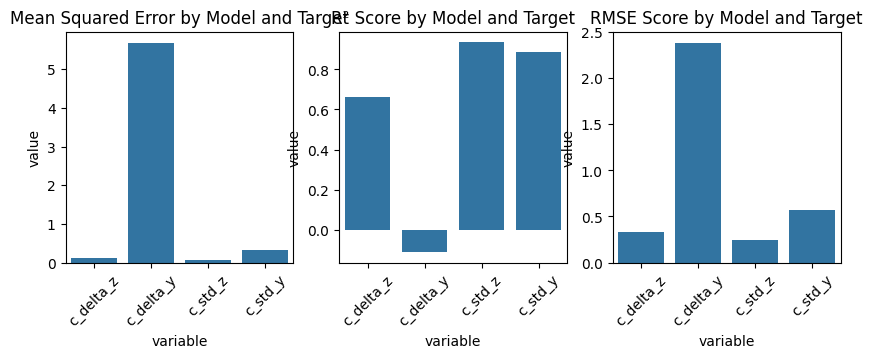

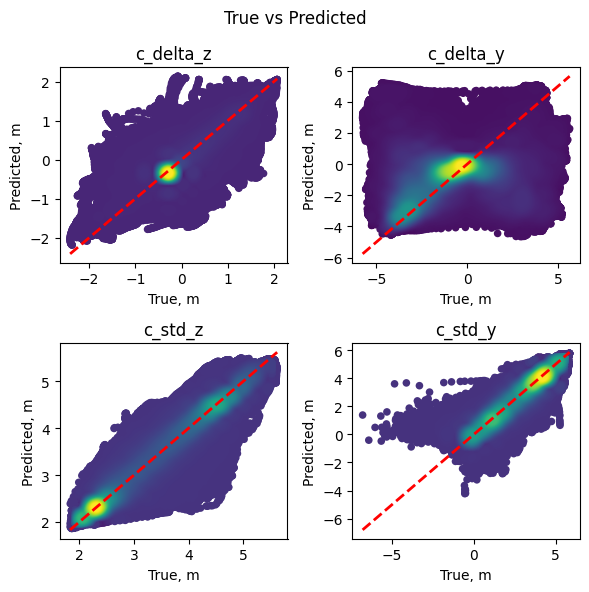

                mse        r2      rmse
c_delta_z  0.113420  0.661021  0.336779
c_delta_y  5.685742 -0.111932  2.384479
c_std_z    0.062575  0.936305  0.250151
c_std_y    0.328156  0.885357  0.572849


In [31]:
# t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test_1)

In [ ]:
pd.DataFrame(y_pred).hist(bins=50)

In [ ]:
pd.DataFrame(y_1).hist(bins=50)

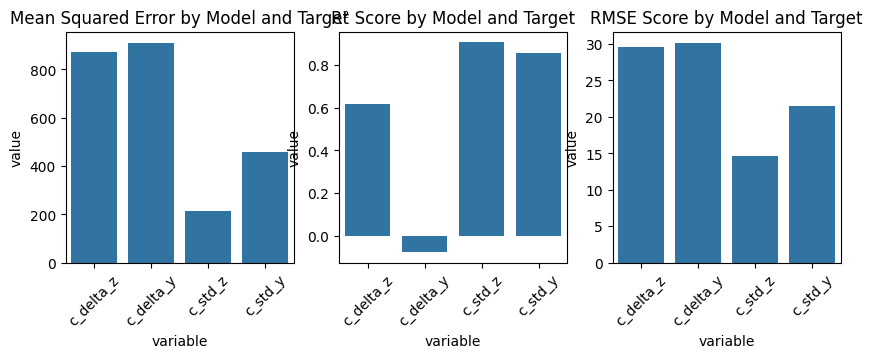

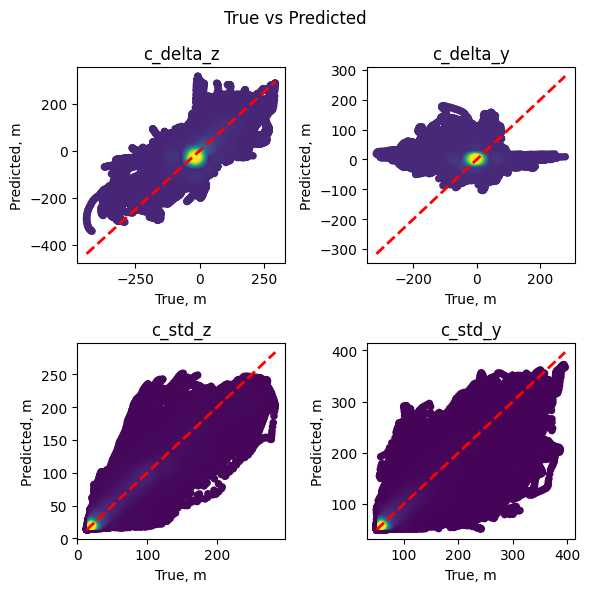

                  mse        r2       rmse
c_delta_z  873.987555  0.619273  29.563281
c_delta_y  911.322691 -0.075573  30.188122
c_std_z    213.927055  0.906868  14.626245
c_std_y    459.690507  0.855489  21.440394


In [32]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

## Do it for means

In [ ]:
# y_pred = pd.DataFrame(y_pred).copy()
# y_pred.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)
# y_test_1.rename(columns={"c_mean_y": "c_delta_y", "c_mean_z": "c_delta_z"}, inplace=True)
# y_test_1["c_mean_y"] += X_test_cut.loc[y_test_1.index, "y"]
# y_pred["c_mean_y"] += X_test_cut.loc[y_test_1.index, "y"]

## -------------

In [ ]:
y_test.hist(bins=50)

In [ ]:
pd.DataFrame(y_pred).hist(bins=50)

## split distances

In [ ]:
# folder_paths = ["output_19_01_2025_2"]
filename_features_cut = "features.csv"
filename_target_23_4375 = "target-23_4375.csv"
filename_target_492_1875 = "target-492_1875.csv"
filename_target_1492_1875 = "target-1492_1875.csv"

In [49]:
features_23_4375, y_test_23_4375 = get_dataset(folder_paths, filename_features_cut, filename_target_23_4375)
features_492_1875, y_test_492_1875 = get_dataset(folder_paths, filename_features_cut, filename_target_492_1875)
features_1492_1875, y_test_1492_1875 = get_dataset(folder_paths, filename_features_cut, filename_target_1492_1875)

(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)
(24192, 9) (24192, 4)


In [ ]:
plt.scatter(np.arange(1, len(y_test_23_4375["c_mean_y"]) +1), y_test_23_4375["c_mean_y"], color="r", alpha=0.5)
plt.scatter(np.arange(1, len(y_test_492_1875["c_mean_y"]) +1), y_test_492_1875["c_mean_y"], color="b", alpha=0.5)
plt.scatter(np.arange(1, len(y_test_1492_1875["c_mean_y"]) +1), y_test_1492_1875["c_mean_y"], color="g",alpha=0.5)

In [55]:
features_23_4375.drop(columns="Tracer", inplace=True)
features_492_1875.drop(columns="Tracer", inplace=True)
features_1492_1875.drop(columns="Tracer", inplace=True)

features_23_4375["distances"] = np.ones(features_23_4375.shape[0]) * 23.4375
features_492_1875["distances"] = np.ones(features_492_1875.shape[0]) * 492.1875
features_1492_1875["distances"] = np.ones(features_1492_1875.shape[0]) * 1492.1875


In [56]:
def del_zeros(X:pd.DataFrame, y: pd.DataFrame):
    #Delete zeros
    mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
    X = X[mask]
    y = y[mask]
    points = np.linspace(0, np.max(y["c_std_y"]), 200)
    quantiles = np.histogram(y["c_std_y"], points)
    hist_mode = quantiles[1][np.argmax(quantiles[0])]
    cut_mask = y["c_std_y"] >= hist_mode
    X = X[cut_mask]
    y = y[cut_mask]
    print(X.shape, y.shape)
    return X, y

In [57]:
features_23_4375, y_test_23_4375 = del_zeros(features_23_4375, y_test_23_4375)
features_492_1875, y_test_492_1875 = del_zeros(features_492_1875, y_test_492_1875)
features_1492_1875, y_test_1492_1875 = del_zeros(features_1492_1875, y_test_1492_1875)


(23752, 9) (23752, 4)
(22588, 9) (22588, 4)
(23673, 9) (23673, 4)


In [ ]:
# t_preproc.transform(y_test_23_4375)
# t_preproc.transform(y_test_492_1875)
# t_preproc.transform(y_test_1492_1875)

In [58]:
y_pred_23_4375 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_23_4375)
    y_pred_23_4375[target] = y_tmp

In [ ]:
t_preproc.inverse_transform(y_pred_23_4375)
performance_visualizations(y_pred_23_4375, y_test_23_4375)

In [ ]:
y_pred_492_1875 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_492_1875)
    y_pred_492_1875[target] = y_tmp
t_preproc.inverse_transform(y_pred_492_1875)
performance_visualizations(y_pred_492_1875, y_test_492_1875)

In [ ]:
y_pred_1492_1875 = {}
for target in y_train.columns:
    y_tmp = model_rf_dict[target].predict(features_1492_1875)
    y_pred_1492_1875[target] = y_tmp
t_preproc.inverse_transform(y_pred_1492_1875)
performance_visualizations(y_pred_1492_1875, y_test_1492_1875)

## Linear

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model_l = LinearRegression()
y_pred = {}
for target in y_train.columns:
    # model_l.fit(X_train, y_train[target])
    model_l.fit(X_train, y_1[target])
    y_tmp = model_l.predict(X_test)
    y_pred[target] = y_tmp

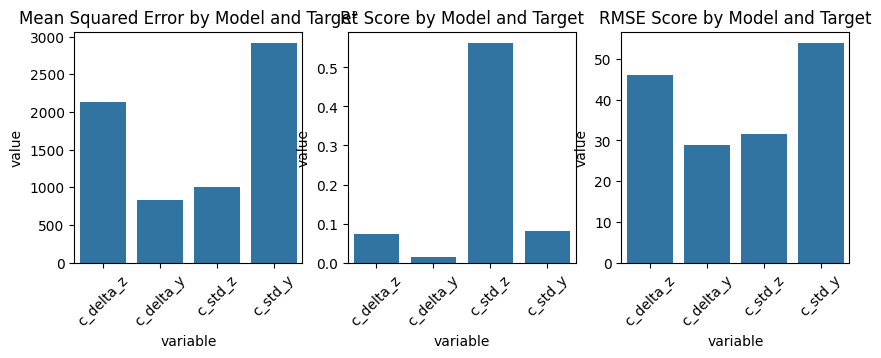

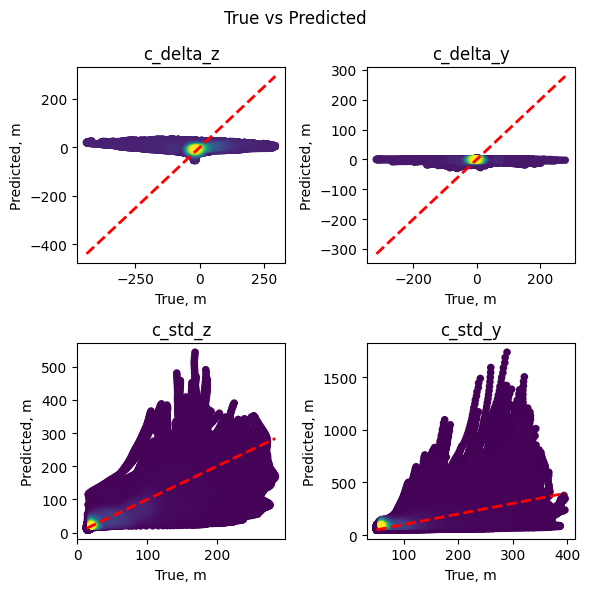

                   mse        r2       rmse
c_delta_z  2127.401872  0.073260  46.123767
c_delta_y   836.243908  0.013038  28.917882
c_std_z    1002.366521  0.563626  31.660172
c_std_y    2919.905196  0.082081  54.036147


In [36]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

In [29]:
data = pd.concat([X, y], axis=1)

In [31]:
data_mean = data.groupby(["distances"]).mean()

In [33]:
data_mean

,y,z,u,power,roughness,T,sensible_heat_flux,T_grad,c_mean_z,c_mean_y,c_std_z,c_std_y
distances,,,,,,,,,,,,
7.8125,1001.734559,351.290196,7.665053,1.250902,0.037143,268.173433,-0.297448,0.050349,370.843550,1002.007957,19.604397,52.477814
23.4375,1001.632416,351.191493,7.667765,1.250856,0.037144,268.174107,-0.297482,0.050339,370.617805,1001.978708,20.237871,52.761649
39.0625,1001.668543,351.217471,7.663441,1.250958,0.037142,268.172827,-0.297429,0.050334,370.476719,1002.087997,20.923410,53.044114
54.6875,1001.646302,351.154107,7.663816,1.250935,0.037154,268.171166,-0.297479,0.050323,370.222365,1002.169458,21.802845,53.463662
70.3125,1001.631246,351.082885,7.658903,1.250815,0.037151,268.166298,-0.297523,0.050333,369.900428,1002.258551,22.741128,53.901989
...,...,...,...,...,...,...,...,...,...,...,...,...
1429.6875,1001.447271,350.847781,7.656765,1.250830,0.037143,268.185822,-0.297425,0.050338,342.128065,1017.408074,75.334870,117.886622
1445.3125,1001.422006,350.795312,7.658297,1.250806,0.037144,268.184346,-0.297461,0.050336,341.972295,1017.426856,75.456020,118.230153
1460.9375,1001.429408,350.797422,7.658819,1.250895,0.037145,268.179631,-0.297448,0.050336,341.629915,1017.712199,75.840806,119.183248


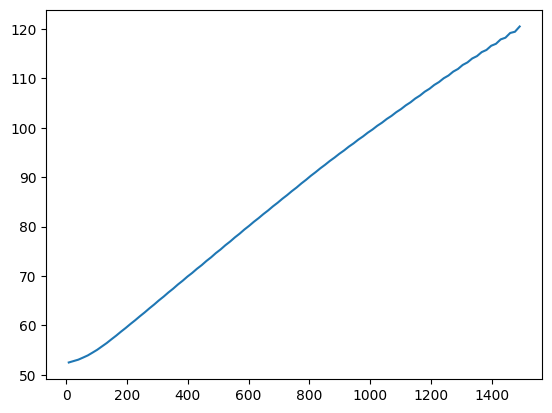

In [ ]:
plt.plot(data_mean.index, data_mean["c_std_y"]) 
# plt.plot(data_mean.index, data_mean["z"], "--r")